# Regressione logistica con Keras
La regressione logistica è un modello di classificazione lineare che ci permete di eseguire classificazioni binomiali, ovvero tra due classi.
<br><br>
Un problema di classificazione può essere ridotto nel trovare i coefficenti della retta che meglio separa gli esempi appartenenti a diverse classi.
<img src="res/classification.png" width="500px" />
<br><br>
In questo notebook eseguiremo una regressione logistica sul [Winsconsis breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)), un dataset contenente proprietà estratte da immagini digitali di tumori al seno.<br>Lo scopo della nostra classificazione è riconoscere un tumore maligno.<br>
Importiamo le librerie che ci serviranno.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
breast_cancer = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",
                           names=["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"])

breast_cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Diamo uno sguardo alle proprietà del dataset.

In [3]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

Il DataFrame contiene 32 colonne, 31 features e una variabile target **diagnosis**, che ci dice se un tumore è maligno o benigno:
* **M** il tuomore è maligno
* **B** il tumore è benigno

## Regressione logistica con due features
Eseguiamo una regressione logistica utilizzando solo due features del dataset:
* **radius_se** l'errore standard del raggio del tumore
* **concave points_worst** il numero peggiore di punti di concavità nel contorno del tumore

Creiamo gli array numpy per addestramento e test.

In [4]:
X = breast_cancer[["radius_se","concave points_worst"]].values
Y = breast_cancer['diagnosis'].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

Le classi di appartenenza sono rappresentate da due label (M, B), utilizziamo il LabelEncoder per convertirli in valori numerici:
* **M => 1 = Classe positiva**
* **B => 0 = Classe negativa**

In [5]:
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.transform(Y_test)

Standardizziamo il DataFrame

In [6]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Adesso possiamo costruire il nostro modello di regressione logistica utilizzando Keras.
<br><br>
La prima cosa da fare è creare un modello sequenziale, possiamo farlo utilizzando la classe <span style="font-family: Monaco">Sequential</span> di Keras. Un modello sequenziale ci permttere di distribuire diversi modelli su livelli diversi, perché dovremmo fare una cosa del genere ? Perchè le reti neurali funzionano così !
<br><br>
Il nostro scopo è creare una semplice modello di regressione logistica e per farlo ci basta aggiungere un unico livello, facciamolo utilizando la classe <span style="font-family: Monaco">Dense</span>, specificando il numero di features all'interno del parametro <span style="font-family: Monaco">input_dim</span> e la funzione di attivazione da utilizzare all'interno del parametro <span style="font-family: Monaco">activation</span>.

In [7]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(1, input_dim=2, activation="sigmoid"))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Dopo aver creato il modello dobbiamo configurare il proceso di addestramento, possiamo farlo utilizzando il metodo compile passando come parametri la funzione di ottimizzazione da utilizzare, la funzione di costo da minimizzare e la metrica da utilizzare.

In [8]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

Adesso che abbiamo configurato la fase di addestramento possiamo avviarla utilizzando il metodo <span style="font-family: Monaco">fit</span> e passando i set di addestramento e il numero di epoche per lo stochastic gradient descent.

In [9]:
model.fit(X_train, Y_train, epochs=25)

Epoch 1/25
398/398 [==============================] - 0s 349us/step - loss: 0.2852 - acc: 0.9422
Epoch 2/25
398/398 [==============================] - 0s 33us/step - loss: 0.2828 - acc: 0.9447
Epoch 3/25
398/398 [==============================] - 0s 35us/step - loss: 0.2804 - acc: 0.9472
Epoch 4/25
398/398 [==============================] - 0s 34us/step - loss: 0.2781 - acc: 0.9472
Epoch 5/25
398/398 [==============================] - 0s 31us/step - loss: 0.2758 - acc: 0.9447
Epoch 6/25
398/398 [==============================] - 0s 34us/step - loss: 0.2736 - acc: 0.9447
Epoch 7/25
398/398 [==============================] - 0s 31us/step - loss: 0.2715 - acc: 0.9447
Epoch 8/25
398/398 [==============================] - 0s 32us/step - loss: 0.2695 - acc: 0.9447
Epoch 9/25
398/398 [==============================] - 0s 38us/step - loss: 0.2675 - acc: 0.9447
Epoch 10/25
398/398 [==============================] - 0s 36us/step - loss: 0.2656 - acc: 0.9447
Epoch 11/25
398/398 [=================

Nel mio caso l'addestramento si è concluso alla 25esima epoca con una accuracy di 0.897 e un loss di 0.3495. Osserviamo le metriche sul set di test utilizzando il metodo <span style="font-family: Monaco">evaluate</span>.

In [10]:
loss, acc = model.evaluate(X_test, Y_test)
print("Loss sul test set: %.4f" % loss)
print("Accuracy sul test set: %.4f" % acc)

171/171 [==============================] - 0s 191us/step
Loss sul test set: 0.2695
Accuracy sul test set: 0.9123


Considerando la semplicità del modello, le metriche sono molto buone.

Visualizziamo il decision boundary sul train_set utilizzano la funzione <span style="font-family: Monaco">showBounds</span> che ho implementato all'interno del file viz.py.

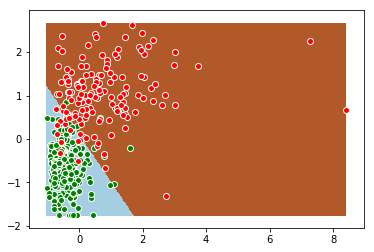

In [11]:
from viz import showBounds

showBounds(X_train, Y_train, model)

e sul test set

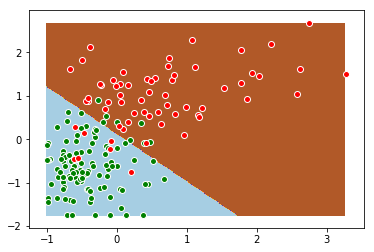

In [12]:
showBounds(X_test, Y_test, model)

**NOTA BENE** Non farti ingannare dai graifici, il confine decisionale è ovviamente sempre lo stesso, sembra essere diverso nei due graifici per il range differente, infatti nel grafico del train set l'ase delle x va da -1 a 8, mentre nel test set va da -1 a 3.

## Regressione logistica con tutte le features
Proviamo a rieseguire la regressione logistica, questa volta utilizzando tutte le proprietà del dataset

In [13]:
X = breast_cancer.drop('diagnosis',axis=1).values
Y = breast_cancer['diagnosis'].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.transform(Y_test)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation="sigmoid"))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=30)

Epoch 1/30
398/398 [==============================] - 0s 376us/step - loss: 0.3614 - acc: 0.8518
Epoch 2/30
398/398 [==============================] - 0s 35us/step - loss: 0.3354 - acc: 0.8568
Epoch 3/30
398/398 [==============================] - 0s 34us/step - loss: 0.3136 - acc: 0.8643
Epoch 4/30
398/398 [==============================] - 0s 34us/step - loss: 0.2953 - acc: 0.8794
Epoch 5/30
398/398 [==============================] - 0s 34us/step - loss: 0.2798 - acc: 0.8894
Epoch 6/30
398/398 [==============================] - 0s 32us/step - loss: 0.2666 - acc: 0.8995
Epoch 7/30
398/398 [==============================] - 0s 31us/step - loss: 0.2549 - acc: 0.9020
Epoch 8/30
398/398 [==============================] - 0s 38us/step - loss: 0.2443 - acc: 0.9070
Epoch 9/30
398/398 [==============================] - 0s 35us/step - loss: 0.2351 - acc: 0.9070
Epoch 10/30
398/398 [==============================] - 0s 34us/step - loss: 0.2268 - acc: 0.9146
Epoch 11/30
398/398 [=================

Verifichiamo il modello utilizzando sempre <span style="font-family: Monaco">accuracy</span>
 e <span style="font-family: Monaco">loss</span>

In [14]:
loss, acc = model.evaluate(X_test, Y_test)
print("Loss sul test set: %.4f" % loss)
print("Accuracy sul test set: %.4f" % acc)

171/171 [==============================] - 0s 221us/step
Loss sul test set: 0.1623
Accuracy sul test set: 0.9357


Avendo più informazioni a disposizione, il modello addestrato con tutte le proprietà è notevolmente migliore.